# Define Exhaustion Signature
## Xiaonan Wang
## 28 Sep 2018

In [2]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
def plotMA(adata, unsName, cidx=0, Cells = None, save=False, padj_cutoff=0.05, logFC_cutoff=1, exp_cutoff=-6, s=1):
    if Cells is not None:
        adata_sub = adata[Cells,:]
    else:
        adata_sub = adata
    print(adata_sub.shape)
    gnames = pd.DataFrame(adata.uns[unsName]['names']).iloc[:,cidx]
    logFC = pd.DataFrame(adata.uns[unsName]['logfoldchanges']).iloc[:,cidx]
    pvals = pd.DataFrame(adata.uns[unsName]['pvals']).iloc[:,cidx]
    padj = pd.DataFrame(adata.uns[unsName]['pvals_adj']).iloc[:,cidx]
    adata_sub = adata_sub.raw[:, gnames].X
    print(adata_sub.shape)
    normExp = np.mean(np.exp(adata_sub)-1, axis=0)
    del adata_sub
    #print(len(normExp))
    #print(len(logFC))
    abs_logFC = logFC.copy()
    abs_logFC[abs_logFC > 4] = 4
    abs_logFC[abs_logFC < -4] = -4
    #import seaborn as sns
    #sns.kdeplot(np.log(normExp))
    logExp = np.log2(normExp)
    idx = (padj < padj_cutoff) & (abs(abs_logFC) > logFC_cutoff)
    upidx = (padj < padj_cutoff) & (abs_logFC > logFC_cutoff) & (logExp > exp_cutoff)
    downidx = (padj < padj_cutoff) & (abs_logFC < -logFC_cutoff) & (logExp > exp_cutoff)
    print('upRegulated gene: '+str(sum(upidx)))
    print('downRegulated gene: '+str(sum(downidx)))
    
    fig = plt.figure()
    plt.scatter(x=logExp, y=abs_logFC, s=s)
    plt.scatter(x=logExp[idx & (logExp > exp_cutoff)], y=abs_logFC[idx & (logExp > exp_cutoff)], c='red',s=s)
    plt.axhline(y=0, color='black')
    plt.axhline(y=logFC_cutoff, color='grey', linestyle = '--')
    plt.axhline(y=-logFC_cutoff, color='grey', linestyle = '--')
    plt.axvline(x=exp_cutoff, color='grey', linestyle = '--')
    plt.xlabel('log2 Mean Exp')
    plt.ylabel('log2 Fold Change')
    plt.grid(b=None)
    plt.show()
    if save:
        fig.savefig('../figures/DEres_'+unsName+'_idx_'+str(cidx)+'.pdf')
    
    Ftable = pd.DataFrame(np.column_stack([gnames, logExp, logFC, pvals, padj]), columns=['GN','logMeanExp', 'logFC', 'pvals', 'padj'])
    return gnames[upidx], gnames[downidx], Ftable

In [21]:
Tcells_data_nor = sc.read('Tcells_nor')
sc.pp.log1p(Tcells_data_nor)

In [2]:
Tcells_data_corrected = sc.read('Tcells_corrected')

In [8]:
print(Tcells_data_corrected.X.shape)

(40557, 999)


In [5]:
UpSig = np.genfromtxt('Exhaustion_UP.txt', delimiter='\t', dtype=str) 
UpSig_all = [x.upper() for x in UpSig]
UpSig = np.intersect1d(Tcells_data_corrected.var_names, UpSig_all)

In [9]:
print(UpSig)
print(len(UpSig))

['BUB1' 'CA2' 'CCL3' 'CCL4' 'CD7' 'CD9' 'CTLA4' 'CXCL10' 'ENTPD1' 'EOMES'
 'FASLG' 'ISG15' 'ISG20' 'LAG3' 'MKI67' 'NR4A2' 'PTGER2' 'RGS16' 'SPP1'
 'TNFRSF9']
20


In [53]:
np.savetxt('UpSig_hvg.txt', UpSig, delimiter='\t', fmt='%s')

In [22]:
Tcells_ex = Tcells_data_nor[:,UpSig]
print(Tcells_ex.X.shape)

(40557, 20)


In [23]:
from scipy import stats
Ex_gmean = stats.gmean(Tcells_ex.X+1,axis=1)
print(len(Ex_gmean))

40557


In [42]:
Ex_gmean_zscore = stats.zscore(Ex_gmean)

In [43]:
Tcells_data_corrected.smp['gmean_test'] = Ex_gmean
Tcells_data_corrected.smp['zscore_test'] = Ex_gmean_zscore

1.0
1.94817


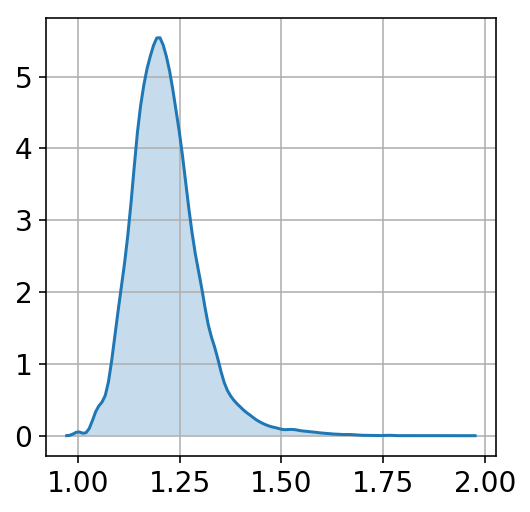

In [54]:
import seaborn as sns
print(min(Ex_gmean))
print(max(Ex_gmean))
sns.kdeplot(Ex_gmean, shade=True)

In [45]:
sns.reset_orig()

In [46]:
print(sum(Ex_gmean>1.4))
print(sum(Ex_gmean_zscore>1.64))

1180
2243


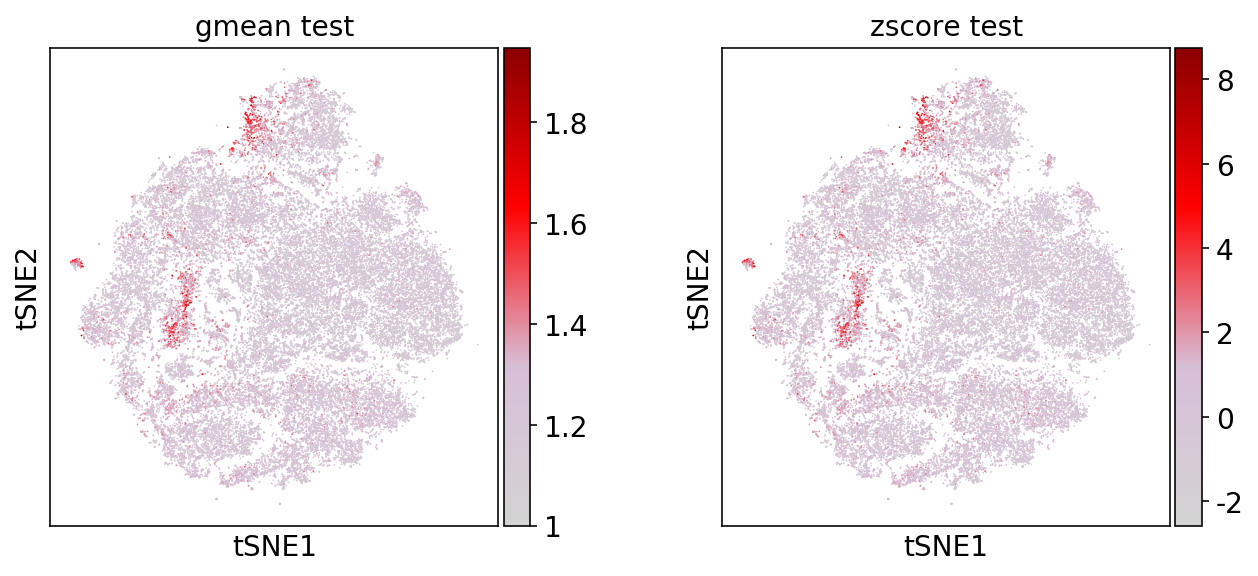

In [47]:
axs = sc.pl.tsne(Tcells_data_corrected, color=['gmean_test', 'zscore_test'], legend_loc='right margin', legend_fontsize=10, color_map=cmap)

In [49]:
Tcells_data_corrected = sc.read('Tcells_corrected')
Tcells_data_corrected.smp['gmean_1.4'] = ['Ex' if x > 1.4  else 'NA' for x in Ex_gmean]

In [38]:
Tcells_data_corrected.add['gmean_1.4_colors'] = ['#8b0000', '#D3D3D3']

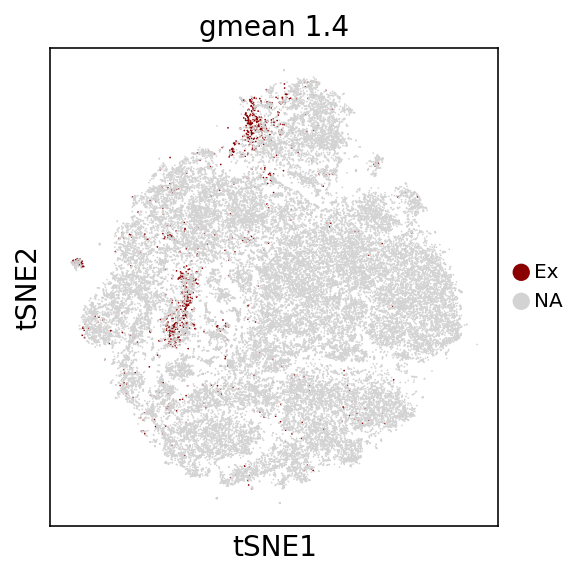

In [39]:
axs = sc.pl.tsne(Tcells_data_corrected, color=['gmean_1.4'], legend_loc='right margin', legend_fontsize=10, color_map=cmap)

In [52]:
sc.write('Tcells_corrected', Tcells_data_corrected)

# Differential expression analysis

In [4]:
Tcells_data = sc.read('../write_new/Tcells_corrected.h5ad', cache=True)

In [9]:
g1 = Tcells_data.obs_names[((Tcells_data.obs['Condition']=='Stimulated') & (Tcells_data.obs['Vector_binary']=='Pos') & (Tcells_data.obs['Ex_Score'] == 'Exhausted') & (Tcells_data.obs['Louvain_Clusters'] == 'L4-6'))] 
temp = Tcells_data[((Tcells_data.obs['Condition']=='Stimulated') & (Tcells_data.obs['Vector_binary']=='Pos') & (Tcells_data.obs['Ex_Score'] == 'Non-exhausted') & (Tcells_data.obs['Louvain_Clusters'] == 'L4-6')),:].copy()
print(temp.shape)
g2 = temp.obs['Ex_gmean'].sort_values().index[0:len(g1)]
CNlist = g1.append(g2)
print(len(CNlist))

(2065, 999)
510


In [10]:
temp = Tcells_data[CNlist,:].copy()

In [11]:
print(temp.shape)

(510, 999)


In [12]:
temp.obs['Con'] = np.concatenate((['g1']*len(g1), ['g2']*len(g2)))

In [13]:
sc.tl.rank_genes_groups(temp, 'Con', n_genes=temp.raw.shape[1], key_added='DE_Ex')

ranking genes


... storing 'Con' as categorical


    finished: added to `.uns['DE_Ex']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [14]:
pd.DataFrame(temp.uns['DE_Ex']['names']).head(10)

,g1,g2
0,CCL3,CACYBP
1,CCL4,HSPD1
2,LAG3,LDHB
3,ENTPD1,RPS2
4,CD7,HMGA1
5,HOPX,PTMA
6,SRGN,MT2A
7,GZMB,HSPE1
8,LGALS1,RPS6
9,CCL5,BTF3


(510, 999)
(510, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 212
downRegulated gene: 47


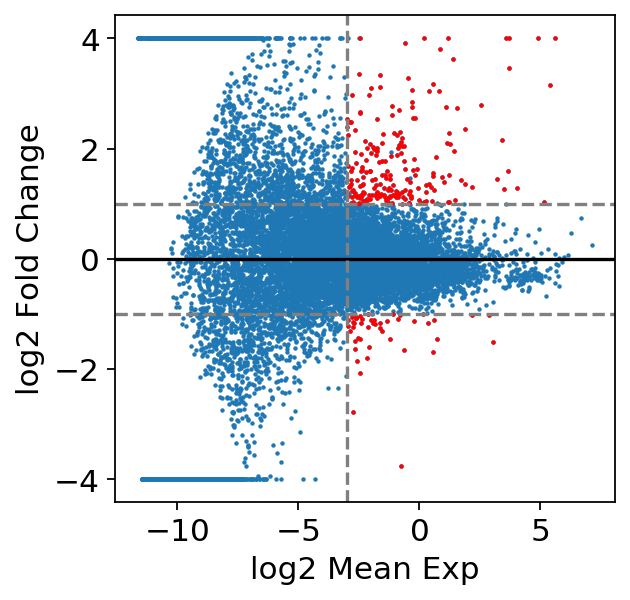

In [15]:
upG, downG, tableG = plotMA(temp, 'DE_Ex',save=True, cidx=0, padj_cutoff=0.05, logFC_cutoff=1, exp_cutoff=-3)
np.savetxt('../DEres/Tcells_Ex/ExvsOthers_upG.txt', upG, delimiter='\t', fmt='%s')
np.savetxt('../DEres/Tcells_Ex/ExvsOthers_downG.txt', downG, delimiter='\t', fmt='%s')
tableG.to_csv('../DEres/Tcells_Ex/ExvsOthers_table.csv')

In [17]:
# Generate pre-ranked list for GSEA
Extab = pd.read_csv('../DEres/Tcells_Ex/ExvsOthers_table.csv', index_col=0)
mod_padj = Extab['padj'].values
mod_padj[mod_padj == 0] = np.min(mod_padj[mod_padj != 0])
mod_padj = mod_padj**(0.01)
print(min(mod_padj))
print(max(mod_padj))
Extab['score'] = (1/mod_padj)*np.sign(Extab['logFC'])
Extab[['GN', 'score']].to_csv('ExDEList_preranked.rnk', sep='\t', header=False, index=False)

0.12410575529775739
1.0


In [ ]:
Tcells_data.write('../write_new/Tcells_corrected.h5ad', cache=True)